In [44]:
import os
import sys

import math

import torch
import pytorch_lightning as pl


In [41]:
# Append python path - needed to import text_recognizer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Model - Linear Regression

In [62]:
class LinearRegression(pl.LightningModule):

    def __init__(self):
        super().__init__()  

        self.model = torch.nn.Linear(in_features=1, out_features=1)

    def forward(self, x):
        return self.model(x)  

    def _run_on_batch(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        xb, yb = batch 
        outs = self(xb)  
        loss = torch.nn.functional.mse_loss(outs, yb)  
        return xb, yb, outs, loss

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        _, _, _, loss = self._run_on_batch(batch, batch_idx)
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)  
        return optimizer

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        _, _, _, loss = self._run_on_batch(batch, batch_idx)
        return loss


In [63]:
trainer = pl.Trainer(max_epochs=20, accelerator="auto")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### DataModule

In [64]:
class CorrelatedDataset(torch.utils.data.Dataset):

    def __init__(self, N=10_000):
        self.N = N
        self.x = torch.randn(size=(N, 1))
        self.y = torch.randn_like(self.x) + self.x  # correlated target data: y ~ N(x, 1)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

    def __len__(self):
        return self.N


class CorrelatedDataModule(pl.LightningDataModule):

    def __init__(self, size=10_000, train_frac=0.8, batch_size=32):
        super().__init__() 
        
        self.size = size
        self.train_frac, self.val_frac = train_frac, 1 - train_frac
        self.train_indices = list(range(math.floor(self.size * train_frac)))
        self.val_indices = list(range(self.train_indices[-1], self.size))

        self.dataset = CorrelatedDataset(N=size)

    def setup(self, stage=None):  
        if stage == "fit" or stage is None:  # other stages: "test", "predict"
            self.train_dataset = torch.utils.data.Subset(self.dataset, self.train_indices)
            self.val_dataset = torch.utils.data.Subset(self.dataset, self.val_indices)

    def prepare_data(self):  # prepares state that needs to be set once per node
        pass  # don't have any "node-level" computations


    def train_dataloader(self: pl.LightningDataModule) -> torch.utils.data.DataLoader:
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=32)

    def val_dataloader(self: pl.LightningDataModule) -> torch.utils.data.DataLoader:
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=32)


### Train model

In [65]:
model = LinearRegression()
datamodule = CorrelatedDataModule()

dataset = datamodule.dataset

print("loss before training:", torch.mean(torch.square(model(dataset.x) - dataset.y)).item())

trainer = pl.Trainer(max_epochs=10, accelerator="auto")
trainer.fit(model=model, datamodule=datamodule)

print("loss after training:", torch.mean(torch.square(model(dataset.x) - dataset.y)).item())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


loss before training: 1.5106819868087769
                                                                            

/Users/niall.turbitt/opt/anaconda3/envs/text-recognizer/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 231.31it/s, loss=1.04, v_num=3] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 230.50it/s, loss=1.04, v_num=3]
loss after training: 1.0125623941421509


In [22]:
example_x, example_y = next(iter(tdl))  # grabbing an example batch to print

print("x:", example_x[:10], sep="\n")
print("y:", example_y[:10], sep="\n")

x:
tensor([[ 1.6128],
        [ 0.4242],
        [ 0.6377],
        [ 0.5423],
        [-0.9728],
        [-0.7131],
        [-0.2382],
        [-0.4210],
        [ 0.2601],
        [ 0.1847]])
y:
tensor([[ 3.3614],
        [ 1.1151],
        [-2.1609],
        [ 2.1232],
        [-0.5070],
        [-0.9894],
        [-0.1715],
        [-0.8713],
        [ 0.4270],
        [-0.8171]])


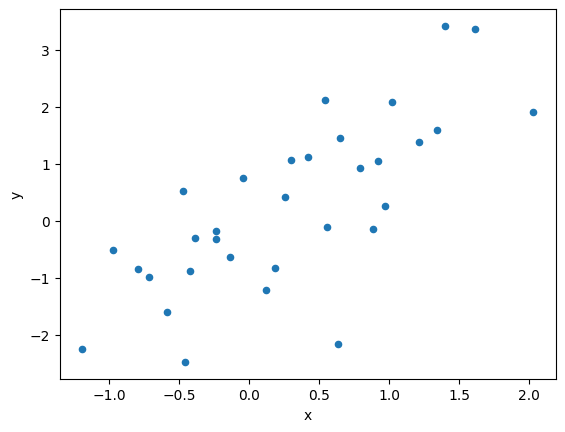

In [24]:
import pandas as pd


pd.DataFrame(data={"x": example_x.flatten(), "y": example_y.flatten()})\
  .plot(x="x", y="y", kind="scatter");

In [26]:
model = LinearRegression()

print("loss before training:", torch.mean(torch.square(model(dataset.x) - dataset.y)).item())

trainer.fit(model=model, train_dataloaders=tdl)

print("loss after training:", torch.mean(torch.square(model(dataset.x) - dataset.y)).item())

Missing logger folder: /Users/niall.turbitt/Projects/text-recognizer/notebooks/lightning_logs

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/Users/niall.turbitt/opt/anaconda3/envs/text-recognizer/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loss before training: 1.3539210557937622
Epoch 19: 100%|██████████| 313/313 [00:01<00:00, 272.32it/s, loss=1.04, v_num=0] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 313/313 [00:01<00:00, 271.04it/s, loss=1.04, v_num=0]
loss after training: 1.0098671913146973


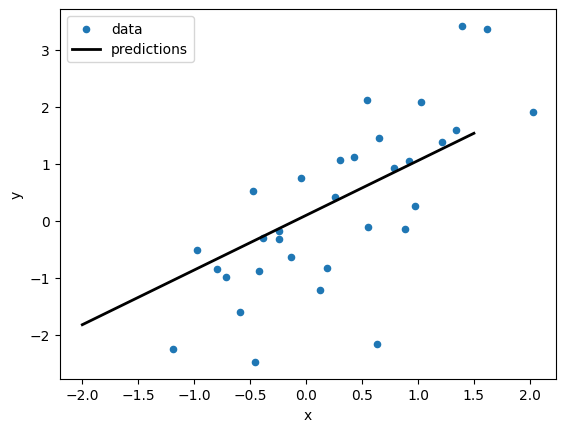

In [66]:
ax = pd.DataFrame(data={"x": example_x.flatten(), "y": example_y.flatten()})\
  .plot(x="x", y="y", legend=True, kind="scatter", label="data")

inps = torch.arange(-2, 2, 0.5)[:, None]
ax.plot(inps, model(inps).detach(), lw=2, color="k", label="predictions"); ax.legend();

In [67]:
torch.arange(-2, 2, 0.5)

tensor([-2.0000, -1.5000, -1.0000, -0.5000,  0.0000,  0.5000,  1.0000,  1.5000])